In [750]:
dir = 'D:/projects/datascience/bfu-ml-labs/lab_8'

In [751]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [752]:
print("CUDA: ", tf.test.is_built_with_cuda())

CUDA:  False


In [753]:
tf.random.set_seed(123)

In [754]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [755]:
type(ds_train)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [756]:
ds_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [757]:
type(ds_test)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [758]:
ds_test

<_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [759]:
type(ds_info)

tensorflow_datasets.core.dataset_info.DatasetInfo

In [760]:
ds_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='C:\\Users\\German\\tensorflow_datasets\\mnist\\3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",


In [761]:
def normalize_image(image_, label_):
    return tf.cast(image_, tf.float32) / 255., label_

In [762]:
ds_train = ds_train.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
# Don't, as we'll re-read the dataset again later for some visualization/testing:     ds_train = ds_train.cache()  # don't!
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [763]:
ds_test = ds_test.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128, drop_remainder=True)
# Don't, as we'll re-read the dataset again later for some visualization/testing:    ds_test = ds_test.cache()  # don't!
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

# 1. MLP

In [764]:
model = tf.keras.models.Sequential([
    # Input layer (28*28=784 neurons).
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    # 3 hidden fully-connected layers (simple feed-forward), each with 100 neurons and with ReLU activation.
    # Each neuron of each layer here is connected to all output values from the previous layer, hence "fully-connected".
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    # Output layer (10 neurons: one for each possible digit (target label) in the dataset: 0, 1, ..., 9).
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

history = model.fit(
    ds_train,
    epochs=5,
    validation_data=ds_test,
)

Epoch 1/5
468/468 [==============================] - 9s 7ms/step - loss: 0.3307 - sparse_categorical_accuracy: 0.9035 - val_loss: 0.1501 - val_sparse_categorical_accuracy: 0.9559
Epoch 2/5
468/468 [==============================] - 4s 5ms/step - loss: 0.1238 - sparse_categorical_accuracy: 0.9626 - val_loss: 0.1185 - val_sparse_categorical_accuracy: 0.9639
Epoch 3/5
468/468 [==============================] - 4s 6ms/step - loss: 0.0894 - sparse_categorical_accuracy: 0.9726 - val_loss: 0.0977 - val_sparse_categorical_accuracy: 0.9689
Epoch 4/5
468/468 [==============================] - 4s 7ms/step - loss: 0.0693 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.0879 - val_sparse_categorical_accuracy: 0.9738
Epoch 5/5
468/468 [==============================] - 5s 5ms/step - loss: 0.0537 - sparse_categorical_accuracy: 0.9833 - val_loss: 0.0855 - val_sparse_categorical_accuracy: 0.9748


In [765]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_18 (Flatten)        (None, 784)               0         
                                                                 
 dense_60 (Dense)            (None, 100)               78500     
                                                                 
 dense_61 (Dense)            (None, 100)               10100     
                                                                 
 dense_62 (Dense)            (None, 100)               10100     
                                                                 
 dense_63 (Dense)            (None, 10)                1010      
                                                                 
Total params: 99,710
Trainable params: 99,710
Non-trainable params: 0
_________________________________________________________________


In [766]:
import numpy as np

X_test = []
y_test = []

for image, label in ds_test.unbatch().as_numpy_iterator():
    X_test.append(image)
    y_test.append(label)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [767]:
X_test.shape

(9984, 28, 28, 1)

In [768]:
y_test.shape

(9984,)

In [769]:
y_pred = model.predict(X_test)

312/312 [==============================] - 7s 2ms/step


In [770]:
type(y_pred)

numpy.ndarray

In [771]:
y_pred.shape

(9984, 10)

In [772]:
y_pred[0]

array([7.0265848e-08, 2.6504247e-07, 9.9991381e-01, 3.8249196e-05,
       1.3502066e-07, 1.2267549e-07, 8.9545807e-07, 1.9644874e-06,
       4.4286691e-05, 7.6433153e-09], dtype=float32)

In [773]:
y_pred_classes = np.argmax(y_pred, axis=1)

In [774]:
y_pred_classes[0]

2

In [775]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       978
           1       0.98      0.99      0.99      1133
           2       0.99      0.97      0.98      1030
           3       0.95      0.98      0.97      1009
           4       0.98      0.97      0.98       980
           5       0.96      0.97      0.97       888
           6       0.98      0.97      0.98       958
           7       0.97      0.97      0.97      1027
           8       0.97      0.95      0.96       973
           9       0.97      0.97      0.97      1008

    accuracy                           0.97      9984
   macro avg       0.97      0.97      0.97      9984
weighted avg       0.97      0.97      0.97      9984



In [776]:
import matplotlib.pyplot as plt


def plot_bars(model_name, y_pred_):
    metric = 'f1-score'

    report = classification_report(y_test, y_pred_, output_dict=True)
    keys = range(10)
    values = [report[str(k)][metric] for k in keys]

    plt.figure(figsize=(5, 5))

    plt.bar(keys, values)
    plt.axhline(np.asarray(values).mean(), c='green', linestyle='dashed')  # average
    plt.axhline(1., c='cyan', linestyle='dashed')  # perfect

    plt.xticks(keys)
    plt.yticks(np.arange(0., 1.05, 0.05))
    plt.xlabel('digit')
    plt.ylabel(metric)
    plt.title('Handwritten Digits Recognition: ' + model_name)

    plt.show()

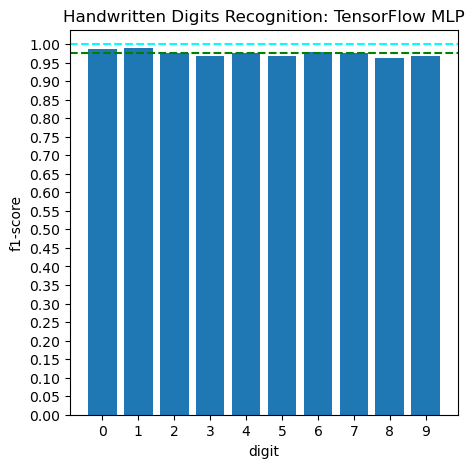

In [777]:
plot_bars('TensorFlow MLP', y_pred_classes)

In [778]:
def plot_learning_curve(history_):
    plt.figure(figsize=(10, 3))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_.history['sparse_categorical_accuracy'], label='Training Accuracy')
    plt.plot(history_.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.xticks(range(len(history_.history)))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.xticks(range(len(history_.history)))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Loss')

    plt.show()

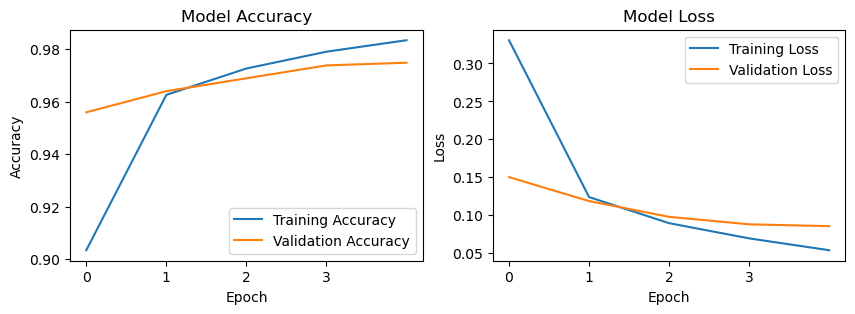

In [779]:
plot_learning_curve(history)

In [780]:
from PIL import Image

In [781]:
image = Image.open(f'{dir}/test_1.png').convert('L').resize((28, 28))  # grayscale 28x28
image

In [782]:
import numpy as np

In [783]:
image_arr = np.array(image) / 256.

In [784]:
type(image_arr)

numpy.ndarray

In [785]:
image_arr.shape

(28, 28)

In [786]:
image_arr

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

In [787]:
image_arr = np.expand_dims(image_arr, axis=0)

In [788]:
type(image_arr)

numpy.ndarray

In [789]:
image_arr.shape

(1, 28, 28)

In [790]:
image_arr

array([[[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.

In [791]:
probabilities = model.predict(image_arr)

1/1 [==============================] - 0s 119ms/step


In [792]:
type(probabilities)

numpy.ndarray

In [793]:
probabilities.shape

(1, 10)

In [794]:
probabilities

array([[5.0661623e-07, 9.9980921e-01, 5.7850053e-07, 1.6511164e-07,
        4.8041689e-05, 3.6817152e-08, 1.2531007e-06, 1.3276910e-04,
        6.4650576e-06, 1.0532278e-06]], dtype=float32)

In [795]:
type(probabilities)

numpy.ndarray

In [796]:
y_pred = np.argmax(probabilities)

In [797]:
type(y_pred)

numpy.int64

In [798]:
y_pred

1

In [799]:
def simple_classify_one_mlp(test_pic_file):
    image = Image.open(f'{dir}/{test_pic_file}').convert('L').resize((28, 28))  # grayscale 28x28

    # For our MLP, we need a 3D array of shape (bach_size, height, width).
    # Here, batch_size = 1 (only 1 image to classify)
    image_arr = np.array(image) / 256.
    image_arr = np.expand_dims(image_arr, axis=0)

    probabilities = model.predict(image_arr)
    y_pred = np.argmax(probabilities)
    y_pred_confidence = float(probabilities[0][y_pred])
    print(f'[MLP] Classification: {y_pred}. Confidence: {round(y_pred_confidence * 100., 2)}%')

In [800]:
simple_classify_one_mlp('test_1.png')

1/1 [==============================] - 0s 30ms/step
[MLP] Classification: 1. Confidence: 99.98%


In [801]:
simple_classify_one_mlp('test_3.png')

1/1 [==============================] - 0s 110ms/step
[MLP] Classification: 3. Confidence: 99.97%


In [802]:
simple_classify_one_mlp('test_8.png')

1/1 [==============================] - 0s 26ms/step
[MLP] Classification: 8. Confidence: 53.06%


In [803]:
simple_classify_one_mlp('test_9.png')

1/1 [==============================] - 0s 26ms/step
[MLP] Classification: 5. Confidence: 37.08%


# 2. CNN

In [804]:
model = tf.keras.models.Sequential([
    # Input layer = Convolution layer #1. Captures some simple low-level patterns.
    tf.keras.layers.Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)),
    # Pooling layer #1. Reduces spatial dimensionality of feature maps from the previous layer,
    #                   while still retaining the most important information.
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # Convolution layer #2. Captures more, higher level patterns.
    tf.keras.layers.Conv2D(64, kernel_size=(5, 5), activation='relu'),
    # Pooling layer #2.
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # Flatten layer. Converts the 3D outputs of the previous layer to a 1D vector
    #                to prepare it for the fully connected layer that goes afterwards.
    tf.keras.layers.Flatten(),
    # Fully connected layer consisting of 500 neurons with ReLU activation.
    tf.keras.layers.Dense(500, activation='relu'),
    # Dropout layer. Helps fight overfitting by randomly deactivating a fraction of neurons at each update.
    tf.keras.layers.Dropout(0.5),
    # Output layer (10 neurons: one for each possible digit (target label) in the dataset: 0, 1, ..., 9).
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

history = model.fit(
    ds_train,
    epochs=5,
    validation_data=ds_test,
)

Epoch 1/5
468/468 [==============================] - 49s 100ms/step - loss: 0.2024 - sparse_categorical_accuracy: 0.9375 - val_loss: 0.0438 - val_sparse_categorical_accuracy: 0.9854
Epoch 2/5
468/468 [==============================] - 51s 105ms/step - loss: 0.0557 - sparse_categorical_accuracy: 0.9826 - val_loss: 0.0299 - val_sparse_categorical_accuracy: 0.9898
Epoch 3/5
468/468 [==============================] - 45s 89ms/step - loss: 0.0393 - sparse_categorical_accuracy: 0.9880 - val_loss: 0.0315 - val_sparse_categorical_accuracy: 0.9897
Epoch 4/5
468/468 [==============================] - 41s 83ms/step - loss: 0.0304 - sparse_categorical_accuracy: 0.9905 - val_loss: 0.0261 - val_sparse_categorical_accuracy: 0.9911
Epoch 5/5
468/468 [==============================] - 40s 83ms/step - loss: 0.0252 - sparse_categorical_accuracy: 0.9919 - val_loss: 0.0253 - val_sparse_categorical_accuracy: 0.9918


In [805]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 64)          51264     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 4, 4, 64)         0         
 g2D)                                                            
                                                                 
 flatten_19 (Flatten)        (None, 1024)              0         
                                                                 
 dense_64 (Dense)            (None, 500)             

In [806]:
y_pred = model.predict(X_test)

312/312 [==============================] - 3s 8ms/step


In [807]:
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       978
           1       1.00      0.99      0.99      1133
           2       1.00      0.99      0.99      1030
           3       0.99      1.00      0.99      1009
           4       0.99      0.99      0.99       980
           5       0.99      0.99      0.99       888
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1027
           8       0.99      1.00      0.99       973
           9       0.99      0.99      0.99      1008

    accuracy                           0.99      9984
   macro avg       0.99      0.99      0.99      9984
weighted avg       0.99      0.99      0.99      9984



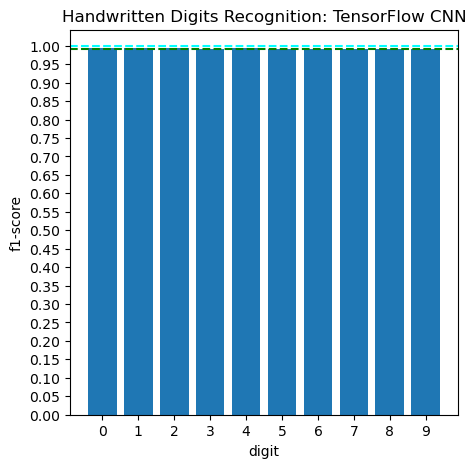

In [808]:
plot_bars('TensorFlow CNN', y_pred_classes)

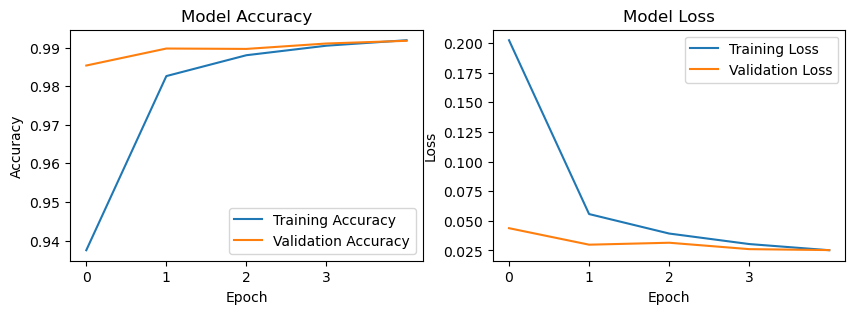

In [809]:
plot_learning_curve(history)

In [810]:
def simple_classify_one_cnn(test_pic_file):
    image = Image.open(f'{dir}/{test_pic_file}').convert('L').resize((28, 28))  # grayscale 28x28

    # For our CNN, we need a 4D array of shape (bach_size, height, width, channels).
    # Here, batch_size = 1 (only 1 image to classify), channels = 1 (grayscale -- just the luminosity).
    image_arr = np.array(image) / 256.
    image_arr = np.expand_dims(image_arr, axis=0)
    image_arr = np.expand_dims(image_arr, axis=-1)

    probabilities = model.predict(image_arr)
    y_pred = np.argmax(probabilities)
    y_pred_confidence = float(probabilities[0][y_pred])
    print(f'[CNN] Classification: {y_pred}. Confidence: {round(y_pred_confidence * 100., 2)}%')

In [811]:
simple_classify_one_cnn('test_1.png')

1/1 [==============================] - 0s 117ms/step
[CNN] Classification: 1. Confidence: 99.99%


In [812]:
simple_classify_one_cnn('test_3.png')

1/1 [==============================] - 0s 26ms/step
[CNN] Classification: 3. Confidence: 100.0%


In [813]:
simple_classify_one_cnn('test_8.png')

1/1 [==============================] - 0s 27ms/step
[CNN] Classification: 8. Confidence: 99.99%


In [814]:
simple_classify_one_cnn('test_9.png')

1/1 [==============================] - 0s 28ms/step
[CNN] Classification: 9. Confidence: 63.46%
